# Data Collection and Wrangling  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine, inspect, text
import sqlite3
import kagglehub
import os

/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Data and Data Wrangling
I'm going to use **SQLite** because it allows me to handle relational data efficiently, especially in a dataset like [Olist Brazilian E-commerce](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce), which includes multiple interconnected tables such as orders, customers, products, payments, and reviews.

Using SQLite has several advantages:
- It supports SQL queries and foreign key constraints, perfect for relational integrity.
- It helps mirror how real-world production systems structure data.
- It allows persistent, lightweight, and fast access to structured data without requiring a separate server.

### Data Workflow Overview:
1. **Load `.csv` files into staging tables (`olist_*`)** using `pandas`.
2. **Create a relational schema** in SQLite with cleaned and typed tables (e.g., `orders`, `customers`, `order_items`, etc.).
3. **Transform and insert** data into final tables with enforced foreign keys, while filtering out duplicates or inconsistent entries.
4. **Run SQL queries and perform analysis** or modeling using joined data.

This approach ensures both flexibility (pandas for EDA and modeling) and integrity (SQL for structure and logic).

In [2]:
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Data saved in:", path)

db_path = "olist.db"
if os.path.exists(db_path):
    os.remove(db_path)

engine = create_engine(f"sqlite:///{db_path}")
conn_sqlite = sqlite3.connect(db_path)


with open("sql/create_schema.sql", "r") as f:
    sql_script = f.read()
conn_sqlite.executescript(sql_script)


tables = [
    "olist_customers_dataset",
    "olist_geolocation_dataset",
    "olist_order_items_dataset",
    "olist_order_payments_dataset",
    "olist_order_reviews_dataset",
    "olist_orders_dataset",
    "olist_products_dataset",
    "olist_sellers_dataset",
    "product_category_name_translation"
]

for table in tables:
    print(f"Loading {table}...")
    df = pd.read_csv(os.path.join(path, f"{table}.csv"))
    df.to_sql(table, engine, index=False, if_exists='replace')

with open("sql/populate_data.sql", "r") as f:
    populate_sql = f.read()

conn_sqlite.executescript(populate_sql)
conn_sqlite.commit()
conn_sqlite.close()

Data saved in: /Users/jacek/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2
Loading olist_customers_dataset...
Loading olist_geolocation_dataset...
Loading olist_order_items_dataset...
Loading olist_order_payments_dataset...
Loading olist_order_reviews_dataset...
Loading olist_orders_dataset...
Loading olist_products_dataset...
Loading olist_sellers_dataset...
Loading product_category_name_translation...


In [3]:
conn = sqlite3.connect(db_path)

for table in tables:
    df = pd.read_sql(f"SELECT * FROM {table}", conn)
    nulls = df.isnull().sum()
    cols_with_nulls = nulls[nulls > 0]
    if not cols_with_nulls.empty:
        print(f"\n{table} — columns with null values:")
        print(cols_with_nulls)


olist_order_reviews_dataset — columns with null values:
review_comment_title      87656
review_comment_message    58247
dtype: int64

olist_orders_dataset — columns with null values:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

olist_products_dataset — columns with null values:
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


### Missing Values Overview and Comment Flag

#### `orders`:
- `order_approved_at` (160), `order_delivered_carrier_date` (1,783), `order_delivered_customer_date` (2,965) are missing, likely due to cancelled or incomplete orders.
These will be filtered contextually, e.g. when analyzing delivery times.

#### `products`:
- 610 missing in metadata (`category`, `name_length`, `description_length`, `photo_qty`) suggest inactive or unregistered products.
- 2 missing in dimensions (`weight`, `length`, `height`, `width`) will be kept or imputed as needed.

#### `order_reviews`:
Sentiment analysis on review comments will not be performed, but it is still useful to capture whether a review included a message.  
A new binary column `has_comment` was added:
- `1` if the customer left a comment
- `0` otherwise

This allows us to use customer engagement as a feature in analysis or modeling, without processing text.

In [4]:
query = """
ALTER TABLE order_reviews ADD COLUMN has_comment INTEGER;
UPDATE order_reviews SET has_comment = CASE WHEN review_comment_message IS NOT NULL THEN 1 ELSE 0 END;
"""
conn.executescript(query)
df = pd.read_sql(f"SELECT * FROM order_reviews", conn)
df["has_comment"].value_counts()

has_comment
0    57742
1    40668
Name: count, dtype: int64

# Exploratory Data Analysis

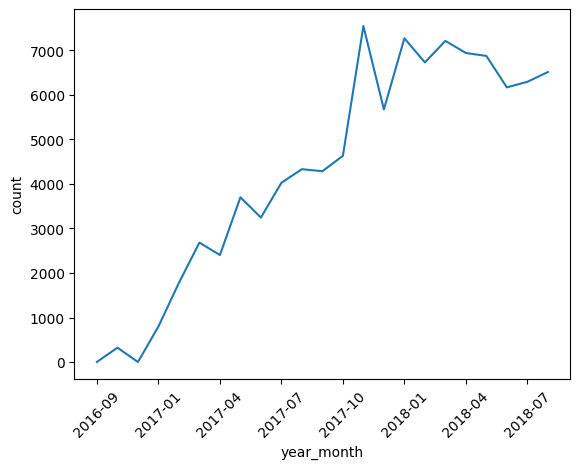

In [5]:
query = """
SELECT STRFTIME('%Y-%m',order_purchase_timestamp) as year_month, COUNT(order_id) AS count 
FROM orders
WHERE order_purchase_timestamp < '2018-09-01'
GROUP BY year_month
"""
df = pd.read_sql(query, conn)
sns.lineplot(data = df, x = 'year_month', y = 'count')
xticks = df['year_month'][::3]  
plt.xticks(ticks=range(0, len(df), 3), labels=xticks, rotation=45)
plt.show()

Note: Data coverage ends in September 2018. The dataset does not include full activity beyond that point.


Let's check what are the most popular product categories:

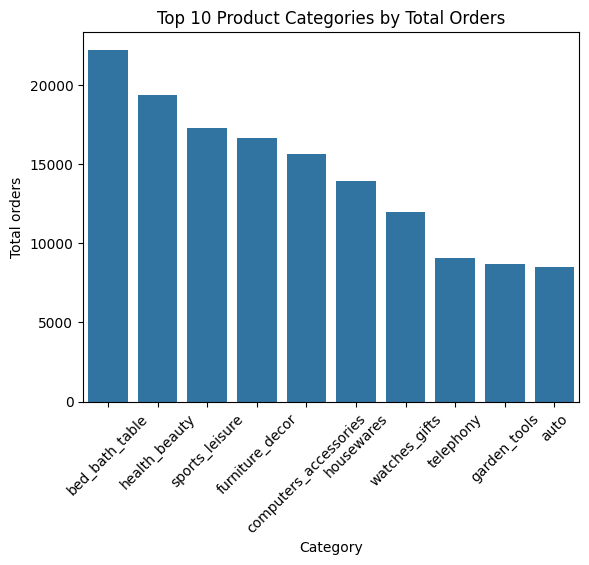

In [6]:
query = """
SELECT 
    t.product_category_name_english AS category, 
    COUNT(*) AS total_orders 
FROM order_items io
JOIN products p ON io.product_id = p.product_id
LEFT JOIN product_category_name_translation t 
    ON p.product_category_name = t.product_category_name
GROUP BY category
ORDER BY total_orders DESC
LIMIT 10

"""
df = pd.read_sql(query, conn)
sns.barplot(data = df, x = 'category', y = 'total_orders')
plt.xticks(rotation = 45)
plt.title('Top 10 Product Categories by Total Orders')
plt.xlabel('Category')
plt.ylabel('Total orders')
plt.show()

The bar chart above illustrates the ten most frequently purchased product categories in the Brazilian e-commerce dataset.

- **cama_mesa_banho** (bedding and bath) and **beleza_saude** (beauty and health) lead the ranking, suggesting high and consistent demand for everyday household and personal care items.
- Categories like **esporte_lazer** (sports and leisure), **moveis_decoracao** (furniture and decor), and **informatica_acessorios** (electronics/accessories) also show strong performance, potentially boosted by seasonal trends or promotional periods.
- The presence of **utilidades_domesticas** (household utilities), **telefonia** (telephony), and **automotivo** (automotive) indicates consumer interest in practical and tech-related products.

This distribution provides a clear overview of customer preferences and can be useful for inventory, marketing, or recommendation strategies.

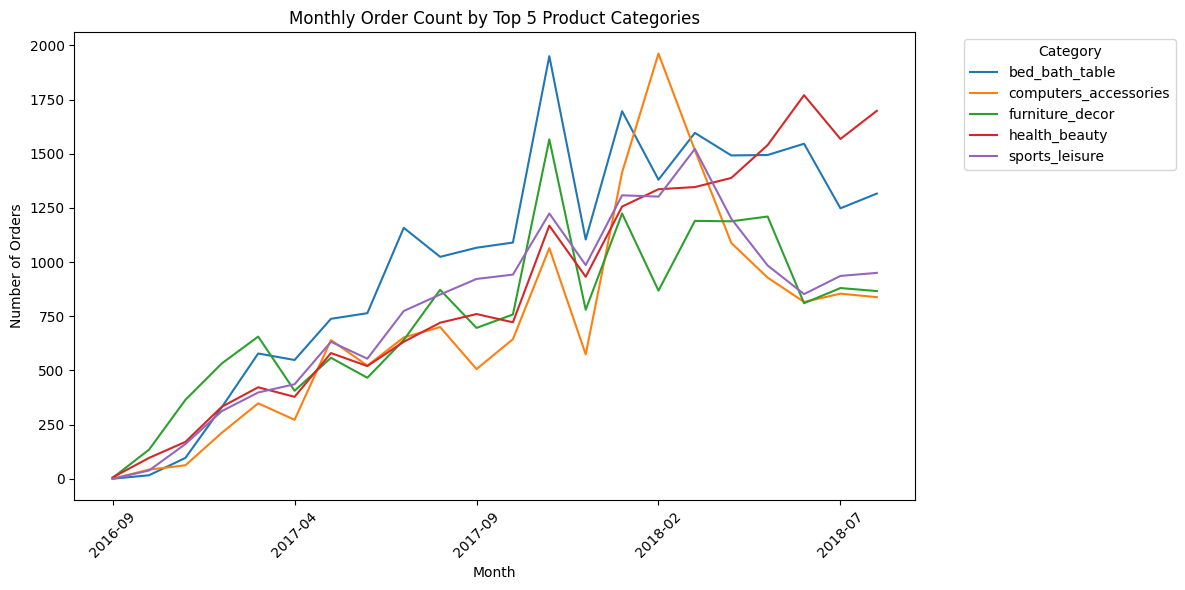

In [7]:
query = """
SELECT 
    STRFTIME('%Y-%m', o.order_purchase_timestamp) AS year_month,
    t.product_category_name_english AS product_category_name,
    COUNT(o.order_id) AS count 
FROM orders o 
JOIN order_items oi ON o.order_id = oi.order_id
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation t 
    ON p.product_category_name = t.product_category_name
WHERE o.order_purchase_timestamp < '2018-09-01'
GROUP BY year_month, t.product_category_name_english
"""

df = pd.read_sql(query, conn)

top5 = df.groupby("product_category_name")["count"].sum().nlargest(5).index
df_top = df[df["product_category_name"].isin(top5)]

pivot = df_top.pivot(index="year_month", columns="product_category_name", values="count").fillna(0)

pivot.plot(kind="line", figsize=(12, 6))
plt.title("Monthly Order Count by Top 5 Product Categories")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The line plot shows the monthly order volume for the top 5 product categories:

- **bed_bath_table** and **health_beauty** show consistent growth over time, indicating strong demand for everyday essentials.
- **computers_accessories** and **furniture_decor** display more volatile patterns, with noticeable peaks likely tied to promotional periods or holidays.
- **sports_leisure** follows a moderate upward trend with occasional dips.

The sharp peaks observed in late Q4 and early Q1 across several categories may reflect **holiday season effects**, such as Black Friday, Christmas, or January clearance sales, which are known to drive higher online sales activity.

It’s important to note that in Brazil, the summer season runs from December to February, including major shopping events like Christmas and New Year's.  
This seasonal context may help explain the increased demand during those months.

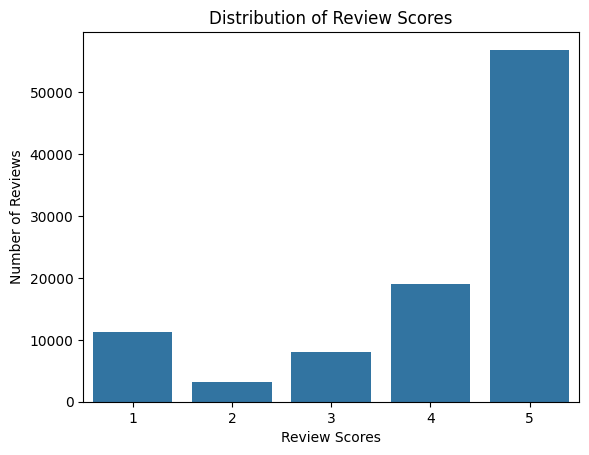

In [8]:
query = """
SELECT review_score, COUNT(review_score) as count
FROM order_reviews
GROUP BY review_score
ORDER BY review_score ASC
"""
df = pd.read_sql(query, conn)
sns.barplot(data = df, x = 'review_score', y = 'count')
plt.title("Distribution of Review Scores")
plt.xlabel("Review Scores")
plt.ylabel("Number of Reviews")
plt.show()

The bar chart above shows the distribution of customer review scores. The ratings range from 1 (very bad) to 5 (excellent).

- The majority of reviews are overwhelmingly **positive**, with score **5** making up the largest portion.
- Low ratings such as **1 and 2** are much less frequent, but still present in non-negligible numbers.
- The relative scarcity of neutral ratings (score 3) suggests that customers are more likely to leave a review when they are either highly satisfied or highly dissatisfied.

This skewed distribution is common in customer review systems and should be considered when building predictive models — for example, by applying techniques like stratified sampling or class balancing.

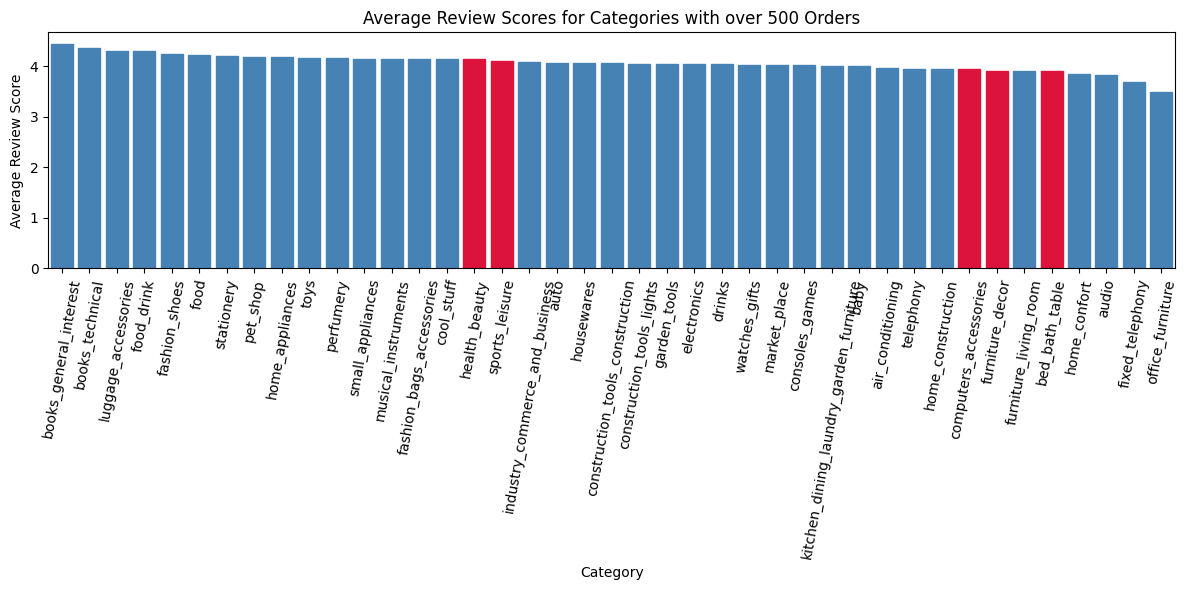

In [9]:
query = """
SELECT 
    t.product_category_name_english AS category, 
    ROUND(AVG(r.review_score), 2) AS review_avg
FROM products p 
JOIN order_items oi ON p.product_id = oi.product_id
JOIN order_reviews r ON oi.order_id = r.order_id
LEFT JOIN product_category_name_translation t 
    ON p.product_category_name = t.product_category_name
GROUP BY category
HAVING COUNT(oi.order_id) > 500
ORDER BY review_avg DESC
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='category', y='review_avg')

for bar, cat in zip(ax.patches, df["category"]):
    if cat in top5:
        bar.set_color("crimson")
    else:
        bar.set_color("steelblue")

plt.title("Average Review Scores for Categories with over 500 Orders")
plt.xlabel("Category")
plt.ylabel("Average Review Score")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [10]:
query = """
SELECT c.customer_state, g.geolocation_lat, g.geolocation_lng, COUNT(c.customer_id) as count
FROM customers c
JOIN geolocation g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY customer_state
"""
df = pd.read_sql(query, conn)

import folium
import folium.plugins as plugins 

brazil_map = folium.Map(location=[-14.2350, -51.9253], zoom_start=5)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius = np.log1p(row['count']) * 2.5,
        popup=f"{row['customer_state']}: {row['count']} customers",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(brazil_map)

brazil_map

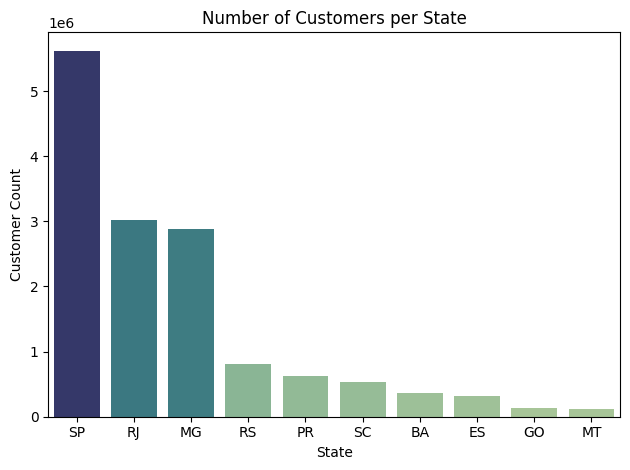

In [11]:
df = df.sort_values(by = 'count', ascending=False).head(10)
sns.barplot(data=df, x='customer_state', y='count', hue = 'count',palette='crest', legend = False)
plt.title("Number of Customers per State")
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

In [12]:
query = """
SELECT s.seller_city, g.geolocation_lat, g.geolocation_lng, ROUND(SUM(oi.price),2) AS total_sum, COUNT(DISTINCT oi.order_id) AS count
FROM sellers s
JOIN order_items oi ON s.seller_id = oi.seller_id
JOIN geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
GROUP BY s.seller_city
ORDER BY total_sum DESC
LIMIT 10
"""
df = pd.read_sql(query, conn)
brazil_map = folium.Map(location=[-29.2350, -49.9253], zoom_start=5)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        popup=f"{row['seller_city'].title()}: {row['total_sum']} BRL",
        color='blue',
    ).add_to(brazil_map)

brazil_map

### Top 10 Seller Cities by Revenue

This map shows the 10 cities in Brazil where sellers generated the highest total sales.

- Data is aggregated by seller city, summing all product prices from orders.
- Geographic coordinates are taken from ZIP code prefixes.
- Each marker shows the city name and total revenue (in BRL).

The map highlights key commercial hubs in the Brazilian e-commerce network.

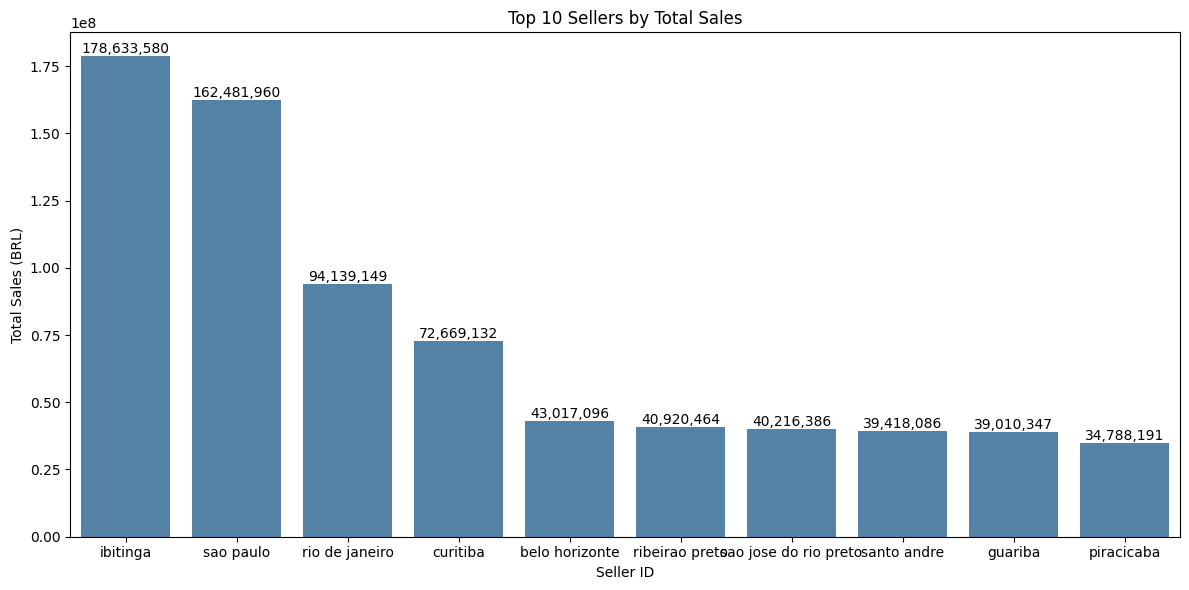

In [13]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='seller_city', y='total_sum',color = 'steelblue',legend = False)
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', labels=[f"{int(v):,}" for v in i.datavalues])
    
plt.title("Top 10 Sellers by Total Sales")
plt.xlabel("Seller ID")
plt.ylabel("Total Sales (BRL)")

plt.tight_layout()
plt.show()

# Market Basket Analysis
### What is Market Basket Analysis (MBA)?

Market Basket Analysis (MBA) is a data mining technique used to discover patterns of items frequently purchased together in the same transaction.  
It answers questions like: **"If a customer buys X, how likely are they to also buy Y?"**

MBA is widely used in e-commerce, retail, and recommendation systems to identify product affinities and improve cross-selling strategies.

### How Does It Work?

MBA uses association rules to find relationships between items. Rules are typically expressed as:

```
{A, B} ⇒ {C}
```

This means: if a customer buys product A and B, they are also likely to buy product C.

### Key Metrics:

- **Support**:  
  Frequency of an itemset in all transactions.  
  _Example: 5% of all orders contain both A and B._

- **Confidence**:  
  How often the rule is true.  
  _Example: Among orders with A and B, 70% also contain C._

- **Lift**:  
  How much more likely C is purchased when A and B are bought, compared to random chance.  
  _Lift > 1 indicates a positive association._


### Why Use MBA?

- Improve product recommendations
- Identify strong product pairings
- Optimize bundles and promotions
- Understand customer purchase behavior

In [14]:
query = """
SELECT 
    oi.order_id, 
    t.product_category_name_english AS product_category_name
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
LEFT JOIN product_category_name_translation t 
    ON p.product_category_name = t.product_category_name
"""

df = pd.read_sql(query, conn)

# Drop rows where category translation is missing
df = df.dropna(subset=['product_category_name'])

# One-hot encoding: each row = order, each column = category (True if present in order)
basket = pd.crosstab(df['order_id'], df['product_category_name'])
basket = basket.astype(bool)

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(basket, min_support=0.00001, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

rules.sort_values(by='confidence', ascending=False).head(10)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(arts_and_craftmanship),(garden_tools),0.000236,0.036173,0.00001,0.043478,1.201968,1.0,1.727716e-06,1.007638,0.168071,0.000282,0.007580,0.021881
1,(garden_tools),(arts_and_craftmanship),0.036173,0.000236,0.00001,0.000284,1.201968,1.0,1.727716e-06,1.000048,0.174337,0.000282,0.000048,0.021881
2,(toys),(arts_and_craftmanship),0.039956,0.000236,0.00001,0.000257,1.088142,1.0,8.328814e-07,1.000021,0.084374,0.000256,0.000021,0.021868
3,(arts_and_craftmanship),(toys),0.000236,0.039956,0.00001,0.043478,1.088142,1.0,8.328814e-07,1.003682,0.081022,0.000256,0.003668,0.021868
4,(auto),(home_comfort_2),0.040070,0.000247,0.00001,0.000257,1.039860,1.0,3.941333e-07,1.000010,0.039932,0.000255,0.000010,0.020962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,"(furniture_decor, pet_shop)",(sports_leisure),0.000021,0.079378,0.00001,0.500000,6.298964,1.0,8.649787e-06,1.841244,0.841261,0.000130,0.456889,0.250065
108,"(sports_leisure, pet_shop)",(furniture_decor),0.000010,0.066310,0.00001,1.000000,15.080788,1.0,9.600338e-06,inf,0.933700,0.000155,1.000000,0.500078
109,(furniture_decor),"(sports_leisure, pet_shop)",0.066310,0.000010,0.00001,0.000155,15.080788,1.0,9.600338e-06,1.000145,1.000000,0.000155,0.000145,0.500078
110,(sports_leisure),"(furniture_decor, pet_shop)",0.079378,0.000021,0.00001,0.000130,6.298964,1.0,8.649787e-06,1.000109,0.913778,0.000130,0.000109,0.250065


In [16]:
rules = rules[
    (rules['confidence'] > 0.1) &
    (rules['lift'] > 1.1)
]
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
9,(home_confort),(bed_bath_table),0.004082,0.096827,0.000442,0.108312,1.118618,1.0,0.000047,1.012881,0.106474,0.004401,0.012717,0.056439
27,(fashion_childrens_clothes),(fashion_bags_accessories),0.000082,0.019166,0.000021,0.250000,13.043991,1.0,0.000019,1.307779,0.923412,0.001070,0.235345,0.125536
34,"(cool_stuff, auto)",(bed_bath_table),0.000031,0.096827,0.000010,0.333333,3.442568,1.0,0.000007,1.354760,0.709541,0.000106,0.261862,0.166720
36,"(auto, bed_bath_table)",(cool_stuff),0.000021,0.037345,0.000010,0.500000,13.388767,1.0,0.000010,1.925311,0.925330,0.000275,0.480603,0.250138
40,"(auto, fashion_bags_accessories)",(musical_instruments),0.000010,0.006457,0.000010,1.000000,154.866242,1.0,0.000010,inf,0.993553,0.001592,1.000000,0.500796


Due to the large number of categories and the sparsity of product combinations in the dataset,  
we reduced the minimum support to `0.00001` in order to capture meaningful but infrequent co-occurrence patterns.  
The final rules were filtered using confidence > 0.1 and lift > 1.1 to retain only relevant associations.

In [17]:
def recommend_from_basket(user_items, rules, top_n=5):
    user_items = set(user_items)
    matched = rules[rules['antecedents'].apply(lambda x: x.issubset(user_items))]
    matched = matched.sort_values(by='confidence', ascending=False)
    recommended = set().union(*matched['consequents']) - user_items
    return list(recommended)[:top_n]

In [18]:
recommend_from_basket(['home_confort'], rules)

['bed_bath_table']

In [19]:
top_rules = rules.sort_values(by = ['confidence','lift'], ascending=False).head(10)
top_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
67,"(bed_bath_table, perfumery)",(market_place),0.00001,0.002879,0.00001,1.0,347.342857,1.0,0.00001,inf,0.997131,0.003571,1.0,0.501786
40,"(auto, fashion_bags_accessories)",(musical_instruments),0.00001,0.006457,0.00001,1.0,154.866242,1.0,0.00001,inf,0.993553,0.001592,1.0,0.500796
41,"(auto, musical_instruments)",(fashion_bags_accessories),0.00001,0.019166,0.00001,1.0,52.175966,1.0,0.00001,inf,0.980844,0.000536,1.0,0.500268
50,"(construction_tools_lights, bed_bath_table)",(garden_tools),0.00001,0.036173,0.00001,1.0,27.645253,1.0,0.00001,inf,0.963837,0.000284,1.0,0.500142
74,"(cine_photo, telephony)",(cool_stuff),0.00001,0.037345,0.00001,1.0,26.777533,1.0,0.00001,inf,0.962665,0.000275,1.0,0.500138
80,"(home_construction, computers_accessories)",(cool_stuff),0.00001,0.037345,0.00001,1.0,26.777533,1.0,0.00001,inf,0.962665,0.000275,1.0,0.500138
42,"(fashion_bags_accessories, musical_instruments)",(auto),0.00001,0.040070,0.00001,1.0,24.956633,1.0,0.00001,inf,0.959940,0.000257,1.0,0.500128
72,"(cool_stuff, cine_photo)",(telephony),0.00001,0.043175,0.00001,1.0,23.161705,1.0,0.00001,inf,0.956835,0.000238,1.0,0.500119
108,"(sports_leisure, pet_shop)",(furniture_decor),0.00001,0.066310,0.00001,1.0,15.080788,1.0,0.00001,inf,0.933700,0.000155,1.0,0.500078
78,"(cool_stuff, home_construction)",(computers_accessories),0.00001,0.068777,0.00001,1.0,14.539692,1.0,0.00001,inf,0.931232,0.000149,1.0,0.500075


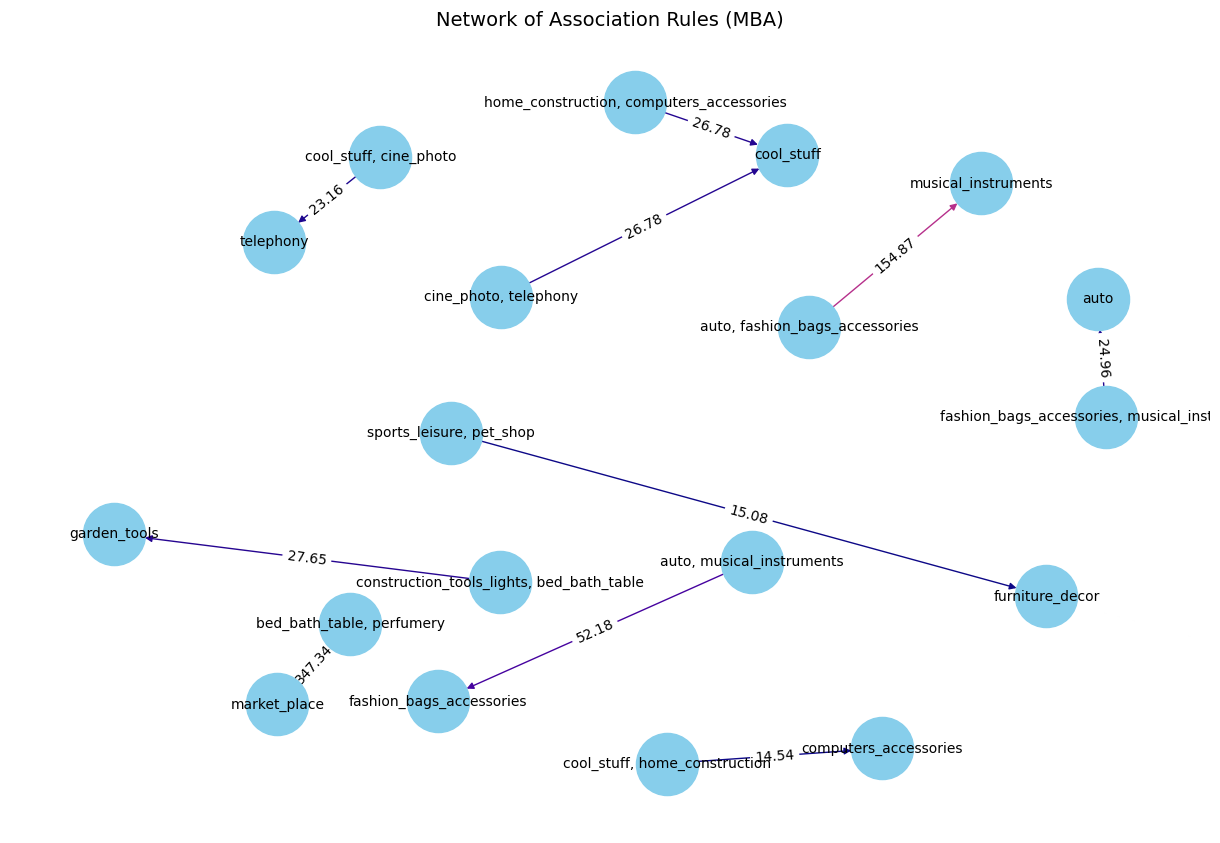

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    G.add_edge(antecedents, consequents, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2.5, iterations=50, seed = 19)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color=weights,
        edge_cmap=plt.cm.plasma,font_size=10, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges})

plt.title('Network of Association Rules (MBA)', fontsize=14)
plt.show()

### Network of Association Rules (Top 10 by Confidence and Lift)

The graph below visualizes the top 10 association rules discovered through Market Basket Analysis.  
Each node represents a product category or a combination of categories, and each directed edge indicates an association rule of the form:

{Antecedent} -> {Consequent}
- **Arrow direction** shows the flow of the rule (from antecedent to consequent).
- **Edge color** reflects the rule's `lift` value, using the `plasma` color map for visual contrast.
- **Edge labels** display the numeric lift value for each rule.
- **Node size and color** are fixed for readability.

The layout was generated using `spring_layout` with a fixed seed (`seed=19`) to ensure consistent spacing and repeatable visualization.

This representation helps identify strong co-purchase patterns and logical groupings of product categories based on consumer behavior.


## Multiclass Classification: Predicting Exact Review Scores (1 to 5)

To gain a more detailed understanding of customer satisfaction, we aim to predict the exact review score (from 1 to 5) a customer will give after an order.

Unlike binary classification, this approach provides more nuance:
- It helps detect borderline cases like frequent 2 or 3-star ratings.
- It allows us to understand what drives truly excellent (5-star) vs. average (3-star) experiences.
- It supports more accurate targeting for improvements in shipping, pricing, or product quality.

### Features used:
- `delivery_time_days` — number of days between approval and delivery  
- `price` — product price  
- `freight_value` — shipping cost  
- `product_category_name` — categorical feature  
- `has_comment` — binary flag if the customer left a comment  

### Target:
- `review_score` ∈ {1, 2, 3, 4, 5}

The goal is to train a supervised classification model that maps the above features to the exact customer review score.


In [21]:
query = """
SELECT
    o.order_id,
    julianday(o.order_delivered_customer_date) - julianday(o.order_approved_at) AS delivery_time_days,
    oi.price,
    oi.freight_value,
    p.product_category_name,
    r.review_score,
    CASE WHEN r.review_comment_message IS NOT NULL THEN 1 ELSE 0 END AS has_comment
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_approved_at IS NOT NULL 
  AND o.order_delivered_customer_date IS NOT NULL
  AND r.review_score IS NOT NULL
  AND oi.price IS NOT NULL
  AND oi.freight_value IS NOT NULL
  AND p.product_category_name IS NOT NULL
"""

df = pd.read_sql(query, conn)

              precision    recall  f1-score   support

           1       0.60      0.53      0.57      2438
           2       0.55      0.21      0.30       720
           3       0.48      0.19      0.27      1812
           4       0.44      0.21      0.29      4147
           5       0.67      0.88      0.76     12402

    accuracy                           0.63     21519
   macro avg       0.55      0.40      0.44     21519
weighted avg       0.59      0.63      0.59     21519



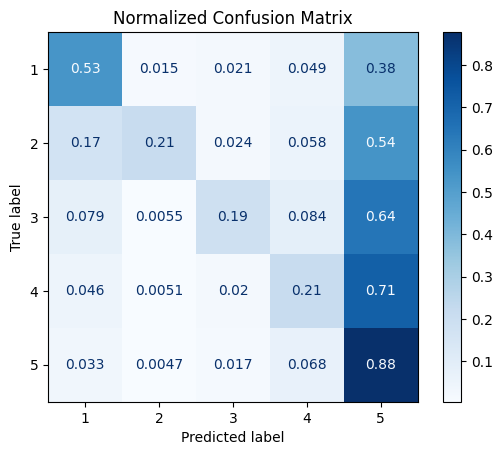

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


features = ['delivery_time_days', 'price', 'freight_value', 'product_category_name', 'has_comment']
target = 'review_score'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing (one-hot encoding for category)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['product_category_name']),
    ],
    remainder='passthrough'  
)

# Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42))
])

# Training
pipeline.fit(X_train, y_train)

# Prediction 
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.show()

## Baseline Model: Random Forest Classifier

As a first step in our predictive modeling process, we implemented a **baseline model** using a Random Forest Classifier to predict exact customer review scores on a 1–5 scale.

### Purpose of the Baseline
The goal of a baseline model is to establish a performance reference point that we can use to evaluate more advanced models later.  
It helps answer the question: _"How well can we perform with minimal feature engineering and a standard classifier?"_

### Model Summary:
- **Algorithm**: Random Forest (multiclass classification)
- **Target**: `review_score` ∈ {1, 2, 3, 4, 5}
- **Features used**:
  - `delivery_time_days`
  - `price`
  - `freight_value`
  - `product_category_name`
  - `has_comment` (binary flag)

### Results:
- **Accuracy**: 63%
- **Precision & Recall**: High for class 5, but significantly lower for scores 2–4
- **Macro average F1-score**: 0.44
- **Class imbalance effect**: The model strongly favors class 5, likely due to its overrepresentation

### Confusion Matrix Observations:
- Majority of misclassifications are directed toward class 5
- Classes 2–4 are often confused with either class 5 or class 1
- Class 3 and 4 predictions are particularly weak

This baseline demonstrates the model's limitations with a small feature set and imbalanced data. In the next step, we will improve feature engineering and experiment with regression-based approaches to better capture the subtleties of customer satisfaction.


In [23]:
query = """
SELECT
    o.order_id,
    o.order_approved_at,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    oi.price,
    oi.freight_value,
    p.product_category_name,
    r.review_score,
    r.review_comment_message,
    pay.payment_value
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products p ON oi.product_id = p.product_id
JOIN order_reviews r ON o.order_id = r.order_id
JOIN order_payments pay ON o.order_id = pay.order_id
WHERE o.order_approved_at IS NOT NULL
  AND o.order_delivered_customer_date IS NOT NULL
  AND o.order_estimated_delivery_date IS NOT NULL
  AND r.review_score IS NOT NULL
  AND p.product_category_name IS NOT NULL
"""
df_raw = pd.read_sql(query, conn)

df_raw['order_approved_at'] = pd.to_datetime(df_raw['order_approved_at'])
df_raw['order_delivered_customer_date'] = pd.to_datetime(df_raw['order_delivered_customer_date'])
df_raw['order_estimated_delivery_date'] = pd.to_datetime(df_raw['order_estimated_delivery_date'])

df_raw['delivery_time_days'] = (df_raw['order_delivered_customer_date'] - df_raw['order_approved_at']).dt.days
df_raw['days_late'] = (df_raw['order_delivered_customer_date'] - df_raw['order_estimated_delivery_date']).dt.days
df_raw['has_comment'] = df_raw['review_comment_message'].notnull().astype(int)

# 
df = df_raw.groupby('order_id').agg({
    'delivery_time_days': 'first',
    'days_late': 'first',
    'price': 'sum',
    'freight_value': 'sum',
    'product_category_name': 'first',
    'review_score': 'first',
    'has_comment': 'first',
    'payment_value': 'first',
    'order_id': 'count'  
}).rename(columns={'order_id': 'num_items'}).reset_index()

In [24]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94036 entries, 0 to 94035
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               94036 non-null  object 
 1   delivery_time_days     94036 non-null  int64  
 2   days_late              94036 non-null  int64  
 3   price                  94036 non-null  float64
 4   freight_value          94036 non-null  float64
 5   product_category_name  94036 non-null  object 
 6   review_score           94036 non-null  int64  
 7   has_comment            94036 non-null  int64  
 8   payment_value          94036 non-null  float64
 9   num_items              94036 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB
None
order_id                 0
delivery_time_days       0
days_late                0
price                    0
freight_value            0
product_category_name    0
review_score             0
has_comment

In [25]:
from xgboost import XGBClassifier
# Data
X = df.drop(columns=['review_score', 'order_id'])
y = df['review_score'] - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# One-hot encoding
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), ['product_category_name'])
], remainder='passthrough')

# Pipeline
model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

# Training
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Raport 
print(classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4], target_names=["1", "2", "3", "4", "5"]))

              precision    recall  f1-score   support

           1       0.56      0.42      0.48      1821
           2       0.07      0.00      0.00       572
           3       0.17      0.00      0.00      1557
           4       0.24      0.01      0.02      3710
           5       0.63      0.97      0.76     11148

    accuracy                           0.62     18808
   macro avg       0.33      0.28      0.25     18808
weighted avg       0.49      0.62      0.50     18808



### XGBoost Classifier for Customer Review Prediction

To improve model performance, we implemented an XGBoost classifier. XGBoost is a gradient boosting algorithm known for high accuracy, built-in regularization, and effective handling of class imbalance.

In our setup, it uses both numerical and categorical features:
- `delivery_time_days`, `days_late`, `price`, `freight_value`, `payment_value`, `num_items`
- `product_category_name` (OneHot encoded)
- `has_comment` (binary flag)

The model captures complex relationships between order characteristics and customer satisfaction, providing a strong upgrade over baseline classifiers like Random Forest.

---

### Reformulating the Task: From 5 to 3 Classes

Due to poor performance on rare classes (scores 2–4), we redefined the problem as a 3-class classification:

- **0**: Negative (scores 1–2)  
- **1**: Neutral (score 3)  
- **2**: Positive (scores 4–5)

This simplifies the task and improves generalization. The model now focuses on identifying sentiment groups instead of exact scores, which is more useful in practice and improves recall for underrepresented classes.


In [26]:
# Recode review scores: 0 = negative (1-2), 1 = neutral (3), 2 = positive (4-5)
y = df['review_score'].apply(lambda x: 0 if x <= 1 else (1 if x == 3 else 2))

# Features 
X = df.drop(columns=['review_score', 'order_id'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing pipeline for categorical variables
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), ['product_category_name'])
], remainder='passthrough')

# Random Forest classifier pipeline
model = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.62      0.34      0.44      1821
     neutral       0.07      0.00      0.01      1557
    positive       0.85      0.98      0.91     15430

    accuracy                           0.84     18808
   macro avg       0.51      0.44      0.45     18808
weighted avg       0.76      0.84      0.79     18808



In [27]:
# Recode review scores: 0 = negative (1-2), 1 = neutral (3), 2 = positive (4-5)
y = df['review_score'].apply(lambda x: 0 if x <= 1 else (1 if x == 3 else 2))

# Features 
X = df.drop(columns=['review_score', 'order_id'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing pipeline for categorical variables
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), ['product_category_name'])
], remainder='passthrough')

# XGB classifier pipeline
model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.63      0.34      0.45      1821
     neutral       0.00      0.00      0.00      1557
    positive       0.85      0.98      0.91     15430

    accuracy                           0.84     18808
   macro avg       0.49      0.44      0.45     18808
weighted avg       0.76      0.84      0.79     18808



### Model Results: Random Forest vs. XGBoost (3-Class Classification)

Both models were trained on the 3-class version of the target:
- **0 = negative (scores 1–2)**
- **1 = neutral (score 3)**
- **2 = positive (scores 4–5)**

#### Performance Summary:

| Class     | f1-score (RF) | f1-score (XGB) | Support |
|-----------|---------------|----------------|---------|
| Negative  | 0.44          | 0.45           | 1,821   |
| Neutral   | 0.01          | 0.00           | 1,557   |
| Positive  | 0.91          | 0.91           | 15,430  |
| **Macro avg** | **0.45**  | **0.45**       | —       |
| **Accuracy**  | **84%**   | **84%**        | 18,808  |

#### Observations:
- Both models perform **very well on the dominant positive class**, which represents close to 82% of the test set.
- **Neutral reviews** are nearly impossible to classify with the current feature set and data distribution.
- **Negative reviews** are partially captured, likely due to features like delay or low price.
- XGBoost **does not provide a noticeable improvement** over Random Forest for this task.

Despite the high overall accuracy, the low macro-averaged f1-score (≈ 0.45) shows that the models are heavily biased toward the majority class.


### RFM Analysis: Customer Segmentation

RFM (Recency–Frequency–Monetary) analysis is a common technique used to segment customers based on their purchase behavior:

- **Recency** – how recently a customer made a purchase
- **Frequency** – how often they purchase
- **Monetary** – how much they spend

This method helps identify key customer groups such as:
- High-value loyal customers
- Active but low-spending buyers
- Inactive or at-risk customers

RFM is widely used in marketing, retention strategies, and personalized targeting.

In [28]:
query = """
SELECT c.customer_id, COUNT(o.order_id) AS Frequency, 
ROUND(julianday((
        SELECT MAX(order_purchase_timestamp) FROM orders
    )) - julianday(MAX(o.order_purchase_timestamp))) AS Recency, 
SUM(op.payment_value) AS Monetary
FROM customers c 
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_payments op ON o.order_id = op.order_id
GROUP BY c.customer_id
"""
df = pd.read_sql(query,conn)
df["Recency"] = df["Recency"].astype(int)
df.head()

,customer_id,Frequency,Recency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,1,337,114.74
1,000161a058600d5901f007fab4c27140,1,458,67.41
2,0001fd6190edaaf884bcaf3d49edf079,1,596,195.42
3,0002414f95344307404f0ace7a26f1d5,1,427,179.35
4,000379cdec625522490c315e70c7a9fb,1,198,107.01


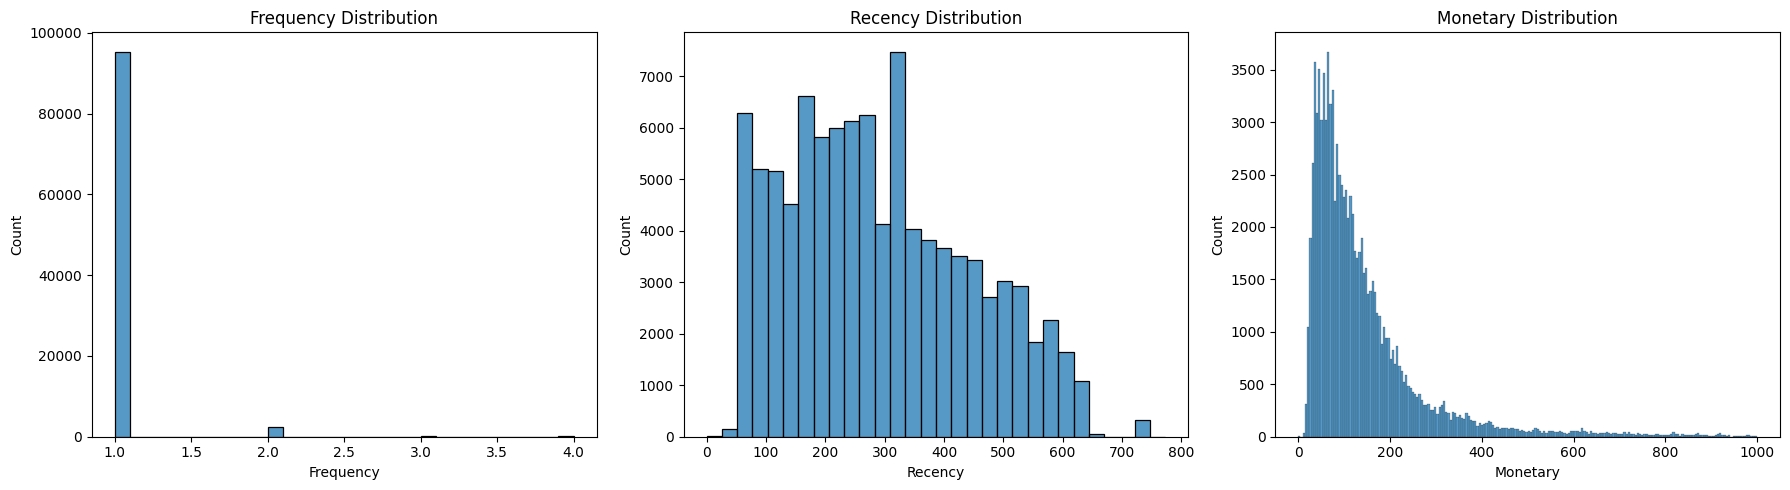

In [29]:
plt.figure(figsize=(18, 5))  
#Filtering out extreme values
df_hist = df[(df["Monetary"]<1000) & (df["Frequency"]<5)]

# 1. Frequency
plt.subplot(1, 3, 1)
sns.histplot(data=df_hist, x="Frequency", bins=30)
plt.title("Frequency Distribution")

# 2. Recency
plt.subplot(1, 3, 2)
sns.histplot(data=df_hist, x="Recency", bins=30)
plt.title("Recency Distribution")

# 3. Monetary
plt.subplot(1, 3, 3)
sns.histplot(data=df_hist, x="Monetary")
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()

In [30]:
df['R_rank'] = pd.qcut(df['Recency'], 4, labels=[4, 3, 2, 1])
df['F_rank'] = pd.qcut(df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
df['M_rank'] = pd.qcut(df['Monetary'], 4, labels=[1, 2, 3, 4])
df.head()

,customer_id,Frequency,Recency,Monetary,R_rank,F_rank,M_rank
0,00012a2ce6f8dcda20d059ce98491703,1,337,114.74,2,1,3
1,000161a058600d5901f007fab4c27140,1,458,67.41,1,1,2
2,0001fd6190edaaf884bcaf3d49edf079,1,596,195.42,1,1,4
3,0002414f95344307404f0ace7a26f1d5,1,427,179.35,1,1,4
4,000379cdec625522490c315e70c7a9fb,1,198,107.01,3,1,3


In [31]:
df["RFM_Score"] = df["R_rank"].astype(str) + df["F_rank"].astype(str) + df["M_rank"].astype(str)

In [32]:
print("How many customers have 444 score:",df[df["RFM_Score"] == "444"]["customer_id"].count())
df[df["RFM_Score"] == "444"].head()

How many customers have 444 score: 1603


,customer_id,Frequency,Recency,Monetary,R_rank,F_rank,M_rank,RFM_Score
663,01aef689891025af290bbdc4788d87da,2,79,371.42,4,4,4,444
1279,0332d8ec6d259a1caeda045188ffe70f,2,107,285.73,4,4,4,444
1455,03a62f764ee7e4701929561d653e4029,2,161,196.68,4,4,4,444
1468,03b243d7ac6a467982044dd9dddb4d68,2,94,583.15,4,4,4,444
1763,047965eae6564b51ea05b945966ec595,2,69,212.89,4,4,4,444


Let's check the extreme `Frequency`, `Recency` and `Monetary` values for the 444 `RFM_Score` clients 

In [33]:
print("Lowest Frequency for 444 clients:",df[df["RFM_Score"] == "444"]["Frequency"].min())
print("Highest Recency for 444 clients:",df[df["RFM_Score"] == "444"]["Recency"].max())
print("Lowest Monetary for 444 clients:",df[df["RFM_Score"] == "444"]["Monetary"].min())

Lowest Frequency for 444 clients: 1
Highest Recency for 444 clients: 166
Lowest Monetary for 444 clients: 176.99


Customers with an `RFM_Score` of **444** represent the top-performing segment:
- **Most recent buyers** (lowest Recency)
- **Most frequent purchasers**
- **Highest spenders**

#### Key statistics for 444 clients:
- **Lowest Frequency**: 1 order  
- **Highest Recency**: 166 days  
- **Lowest Monetary value**: 176.99 BRL

Although some customers in this group have only made one order, they still qualify due to:
- Very recent purchases
- High monetary value

This suggests that a **single high-value, recent purchase** can qualify a customer for the top segment, emphasizing the importance of recency and spending in this dataset.

In [34]:
print("Highest Frequency for 111 clients:",df[df["RFM_Score"] == "111"]["Frequency"].max())
print("Lowest Recency for 111 clients:",df[df["RFM_Score"] == "111"]["Recency"].min())
print("Highest Monetary for 111 clients:",df[df["RFM_Score"] == "111"]["Monetary"].max())

Highest Frequency for 111 clients: 1
Lowest Recency for 111 clients: 401
Highest Monetary for 111 clients: 62.01


Customers with an `RFM_Score` of **111** fall into the lowest-performing segment:
- **Haven’t purchased in a long time**
- **Made only one purchase**
- **Spent very little**

#### Key statistics for 111 clients:
- **Highest Frequency**: 1 order  
- **Lowest Recency**: 401 days  
- **Highest Monetary value**: 62.01 BRL

These customers are inactive, low-value buyers who have not returned to the platform in over a year. They are unlikely to convert again without targeted reactivation strategies, and may not be worth further investment in most cases.

This sharply contrasts with the `444` segment, emphasizing how RFM can clearly separate valuable, engaged customers from inactive or one-time users.

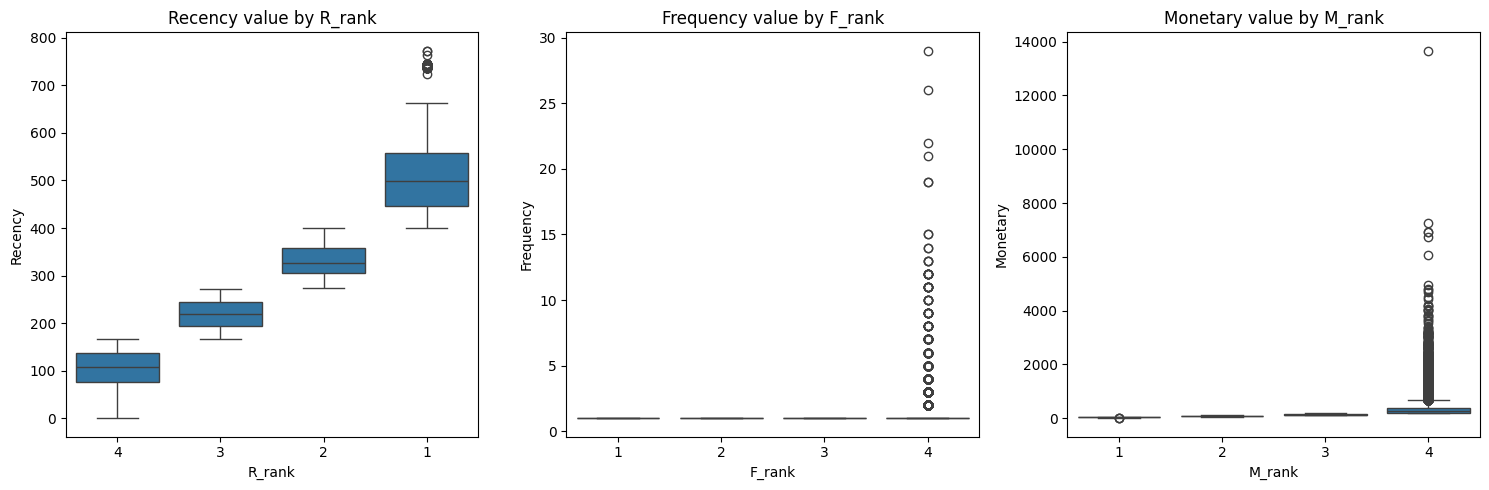

In [35]:
features = [['Recency', 'R_rank'], ['Frequency', 'F_rank'], ['Monetary','M_rank']]

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(x=feature[1], y=feature[0], data=df)
    plt.title(f'{feature[0]} value by {feature[1]}')

plt.tight_layout()
plt.show()

### Boxplots: Value Distributions by RFM Rank

The following plots show how each raw RFM metric varies across its corresponding quantile-based rank:

- **Recency vs R_rank**: Lower `R_rank` corresponds to longer time since last purchase (i.e., less recent activity). The trend is clearly increasing.
- **Frequency vs F_rank**: Frequency increases significantly in the top rank (4), while other ranks have relatively low values.
- **Monetary vs M_rank**: Spending is concentrated in the top monetary rank, with a large number of outliers. Most customers in lower ranks spend very little.

These distributions confirm that the ranking mechanism effectively separates customers by purchase behavior and allows for interpretable segmentation.


### Final Summary and Insights

This project focused on analyzing customer behavior and purchase patterns in the Brazilian e-commerce market using a rich, relational dataset from Olist.

#### Key Areas Covered:
- **Relational Data Modeling (SQL + SQLite):**
  - Clean schema design with enforced foreign key integrity
  - Joined multiple tables for analysis: orders, payments, reviews, customers, sellers

- **Review Score Prediction:**
  - Random Forest and XGBoost models were trained to classify customer reviews.
  - Models predicted the positive class well (f1 ~0.91), but neutral and negative reviews were difficult to distinguish due to data imbalance and limited feature variance.

- **Market Basket Analysis:**
  - Association rules were extracted between product categories using Apriori algorithm.
  - A network graph revealed common category pairs bought together.

- **Customer Segmentation (RFM Analysis):**
  - RFM metrics were calculated directly in SQL.
  - Customers were ranked based on Recency, Frequency, and Monetary value.
  - Segment `444` (best customers) and `111` (inactive, low-value) were identified clearly.
  - Visualizations such as histograms, boxplots, and heatmaps showed strong separation between segments.

#### Business Recommendations:
- **Prioritize 444 customers** through loyalty programs and exclusive offers — they buy recently, frequently, and spend the most.
- **Reactivation campaigns** could be tested on intermediate segments (e.g., `RFM_Score = 344`, `244`) where value is moderate but recency is declining.
- **Limit marketing budget** for `111` segment — these customers are inactive and low-spending.
- Consider enriching the dataset further (e.g., NLP on review comments, delivery delays) to improve model performance.

This project demonstrates the integration of SQL-based data engineering, predictive modeling, and behavioral segmentation — offering a full-stack view of customer analytics that could support real-world CRM or marketing strategies.
